In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
import seaborn as sns 
import math
import random
from scipy.integrate import simps
from sklearn.manifold import TSNE
from scipy.integrate import simps
from scipy import stats
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from statannot import add_stat_annotation
import scipy.signal
from scipy.stats import exponnorm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from lmfit.models import GaussianModel
from lmfit.models import GaussianModel,ExponentialGaussianModel,SkewedGaussianModel,VoigtModel,LorentzianModel,LognormalModel
from scipy.signal import savgol_filter, find_peaks, find_peaks_cwt
from scipy import sparse
from scipy.sparse.linalg import spsolve
import scipy
import pybaselines
from numpy import genfromtxt
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["font.family"] = "Arial"
sns.set(font_scale=2)
sns.set_style("white")

# Figure 5 Code 

This file was used to generate figures 5 B and C as well as supplemental figure 2


In [2]:
#useful functions 

def make_entry(csv, sample_name,topfluor_normalization=1): 
    """
    Inputs: HPLC trace (csv), lipid class (string), genetic background (string),multiplier (to make visible int)
    and topfluor (an int representing the amount of topfluor in the sample that is used as a normalization control)
    Outputs: An array of dictionaries for each moment in the hplc trace 
    """
    hplc=[]
    area=0
    for row in csv.itertuples():
        area+=row[3]
    area=area/100
    #iterates through the rows of the CSV and adds a dictionary entry for that time point 
    for row in csv.itertuples():
        #iterates through the rows of the CSV and adds a dictionary entry for that time point 
        if isinstance(row[3],str):
            hplc.append({"Time":row[1],"Value":float(row[3].replace(',',''))/topfluor_normalization, "Name":sample_name})
        else: 
            hplc.append({"Time":row[1],"Value":row[3]/area, "Name":sample_name})
              

    return hplc 

def normalize_area(csv):
    area=0
    for row in csv:
        area+=row[2]
    
    area=area/100
    csv[:,2]=csv[:,2]/area
    return csv
def concatenate(csv1,csv2,csv3,offset1,offset2,sample_name,modifier=1):
    """
    Inputs: hplc traces, time offset 1, time offset 2 
    
    
    """
    hplc=[]
    area1=0
    maximum=0
    center=0
    for i in range(0,len(csv1)):
                   
        area1+=csv1[i][2]
        if csv1[i][2]>maximum and csv1[i][0]>5:
            maximum=csv1[i][2]
            center=csv1[i][0]

    for i in range(0,len(csv1)):
        
        row=csv1[i]
        if row[0]>12 and row[0]<17:
            val1=row[2]
            row2=csv2[i-offset1]
            if row2[0]<12 or row2[0]>17:
                val2=0
            else:
                val2=row2[2]*modifier
            row3=csv3[i-offset2]
            if row3[0]<12 or row3[0]>17:
                val3=0
            else:
                val3=row3[2]
        else: 
            val1=0
            row2=csv2[i-offset1]
            if row2[0]<12 or row2[0]>17:
                val2=0
            else:
                val2=row2[2]
            row3=csv3[i-offset2]
            if row3[0]<12 or row3[0]>17:
                val3=0
            else:
                val3=row3[2]
            
        hplc.append({"Time":row[0],"Value":((val1+val2+val3)/area1)*100, "Name":sample_name})
    

    return hplc,center,maximum
        
        
    
def model_n_expgaus(x,y,number_peaks,min_number_peaks,peak_locations,peak_heights):
    """
    Inputs: x and y axises to be fitted, the number of peaks to create and the approximate peak locations 
    Outputs: Array of tuples (peak location, peak area)
    Prints: Summary graphs showing initial and final fit, and showing the locations of gaussian components 
    """
  
    #goes from max to min number of peaks, finds bic, removes smallest peak, repeat 
    model=''
    for n in range(0,number_peaks):
        gaus=ExponentialGaussianModel(prefix='p'+str(n)+"_")
        #addition of first model for first peak
        if model=='':
            model=gaus
            pars=gaus.make_params(prefix='p'+str(n)+"_")
            #peak locations can vary by 1 min 
            pars['p'+str(n)+'_center'].set(value=peak_locations[n],min=peak_locations[n]-0.1,max=peak_locations[n]+0.1)
            #sigma can only be so large and small 
            pars['p'+str(n)+'_sigma'].set(value=0.05, min=0.0001,max=1)
            #amplitude can only be so small to be a real peak 
            pars['p'+str(n)+'_amplitude'].set(value=peak_heights[n], min=0.001,max=peak_heights[n]*1.1)
            pars['p'+str(n)+'_gamma'].set(value=1,max=5,min=0.0001)
        #all subsequent peaks    
        else:
            model+=gaus
            pars.update(gaus.make_params(prefix='p'+str(n)+"_"))
            pars['p'+str(n)+'_center'].set(value=peak_locations[n],min=peak_locations[n]-0.1,max=peak_locations[n]+0.1)
            pars['p'+str(n)+'_sigma'].set(value=0.05, min=0.0001,max=1)
            pars['p'+str(n)+'_amplitude'].set(value=peak_heights[n], min=0.001,max=peak_heights[n]*1.1)
            pars['p'+str(n)+'_gamma'].set(value=1,max=5,min=0.0001)
    #Uses gradient descent to best fit model 
    result = model.fit(y, pars, x=x)



    # plot results

    #intial fit 
    init = model.eval(pars, x=x)
    #to get best fit 
    out = model.fit(y, pars, x=x)

    comps=out.eval_components(x=x) 
    areas=[]
    for n in range(0,number_peaks):
        area=sum(comps['p'+str(n)+"_"])*0.01
        areas.append(area)





    min_ind=areas.index(min(areas))
    peak_locations = np.delete(peak_locations, min_ind)
    areas= np.delete(areas, min_ind)
    number_peaks-=1

    
    """
    fig, axes = plt.subplots(1, 1, figsize=(10,10))

    axes.set_xlabel('Time (min)')
    axes.set_ylabel('Peak Area (pA)')
    """
    #plots underlying data
    #axes[0].plot(x, y)
    #plots initial fit in orange with dashed line 
    #axes[0].plot(x, init, '--', label='initial fit')
    #plots best fit in green with solid line 
    #axes.plot(x, out.best_fit, '-', label='best fit')
    #axes[1].plot(x, out.best_fit, '-', label='best fit')
    #axes.legend()

    #find the components of the best fit curve 
    #plots underlying data 
    """
    plt.style.use("fast")
    axes.plot(x, y,color='r')
    """
    
    areas=[]
    #plots each peak 
    for n in range(0,number_peaks+1):
        """
        sns.set_style("ticks")
        axes.plot(x, comps['p'+str(n)+"_"], '--', label='Gaussian component '+str(n))
        axes.fill_between(x, comps['p'+str(n)+"_"].min(), comps['p'+str(n)+"_"], alpha=0.5) 
        axes.plot(x, out.best_fit, '-', label='best fit',color='k')
        #axes.legend()
        axes.set_xlabel("Time (min)",size=30)
        axes.set_title("Exponential Gaussian Fit",size=30)
        axes.set_ylabel("Peak Area (pA)",size=30)
        """
        #adds peak location on the actual output graph 
        #axes[1].text(out.params['p'+str(n)+"_center"].value, out.params['p'+str(n)+"_amplitude"].value+1, str(out.params['p'+str(n)+"_center"].value)[0:5], fontsize=8,horizontalalignment='center')
        #calculates the area which is amplitude(SD)/(1/sqrt(2*pi))
        
        area=sum(comps['p'+str(n)+"_"])*0.01
        center=out.params['p'+str(n)+"_center"].value
        gamma=out.params['p'+str(n)+"_gamma"].value
        amplitude=out.params['p'+str(n)+"_amplitude"].value
        sigma=out.params['p'+str(n)+"_sigma"].value
        areas.append([center,gamma,amplitude,sigma,area])
    
        #axes[1].legend()
    """
    plt.show()
    """
    return(areas)

def find_error(x,y,center,gamma,amplitude,sigma,modifier):
    model=''
    for n in range(0,1):
        gaus=ExponentialGaussianModel(prefix='p'+str(n)+"_")
        #addition of first model for first peak
        if model=='':
            model=gaus
            pars=gaus.make_params(prefix='p'+str(n)+"_")
            #peak locations can vary by 1 min 
            pars['p'+str(n)+'_center'].set(value=center,min=10,max=20)
            #sigma can only be so large and small 
            pars['p'+str(n)+'_sigma'].set(value=sigma,vary=False)
            #amplitude can only be so small to be a real peak 
            pars['p'+str(n)+'_amplitude'].set(value=amplitude,vary=False)
            pars['p'+str(n)+'_gamma'].set(value=gamma,vary=False)


    #to get best fit 
    out = model.fit(y, pars, x=x)

    comps=out.eval_components(x=x)
    """
    fig, axes = plt.subplots(1, 1, figsize=(10,10))
    
    axes.set_xlabel('Time (min)')
    axes.set_ylabel('Peak Area (pA)')
    #plots underlying data
    #axes[0].plot(x, y)
    #plots initial fit in orange with dashed line 
    #axes[0].plot(x, init, '--', label='initial fit')
    #plots best fit in green with solid line 
    #axes.plot(x, out.best_fit, '-', label='best fit')
    #axes[1].plot(x, out.best_fit, '-', label='best fit')
    #axes.legend()

    #find the components of the best fit curve 
    #plots underlying data 
    plt.style.use("fast")
    axes.plot(x, y,color='r')
    areas=[]
 



    # plot results

 
    #plots each peak 
    for n in range(0,1):
        sns.set_style("ticks")
        axes.plot(x, comps['p'+str(n)+"_"], '--', label='Gaussian component '+str(n))
        axes.fill_between(x, comps['p'+str(n)+"_"].min(), comps['p'+str(n)+"_"], alpha=0.5) 
        axes.plot(x, out.best_fit, '-', label='best fit',color='k')
        #axes.legend()
        axes.set_xlabel("Time (min)",size=30)
        axes.set_title("Exponential Gaussian Fit",size=30)
        axes.set_ylabel("Peak Area (pA)",size=30)
    """
    print(out.chisqr/(0.33*modifier**2))
    return(out.chisqr/(0.33*modifier**2))
def find_thermo_error(x,y,shift,df,start,end,area):
    error=0
    p=df.loc[(df["Time"]>=10) & (df['Time']<=30)]['Time']
    
    p=p-(shift/600)

    start_index=p[p > 10].index[0]-5939
    start=start-(shift/600)
    end=end-(shift/600)
    q=df.loc[(df['Time']>=10) & (df['Time']<=30)]['Value']
    """
    fig,ax=plt.subplots(1,1)
    
    ax.plot(x,y)
    ax.plot(p,q)
    ax.set(xlim=(10,30))
    ax.fill_between(p, q, alpha=0.75,color='orange',where=((p>start)&(p<end)))
    plt.show()
    """


    total=0
    for a,b,c,d in zip(y,q[start_index:],p[start_index:],x):
        
        if d>=start and d<=end:
            error+=(a-b)*(a-b)
            total+=b
        else:
            error+=a*a
            
    rmse=error/area

    return rmse
    

    

def merge_peaks(peak_list,shoulder_list):
    merged_list=[]
    for peak in peak_list:
        merged_list.append(peak)
    for peak in shoulder_list:
        include=True
        for peak2 in peak_list:
            if abs(peak-peak2)<150:
                include=False
        if include:
            merged_list.append(peak)
    merged_list = np.delete(merged_list, np.argwhere(np.ediff1d(merged_list) <= 150)+1)
    return merged_list

def find_locations_peaks(data,peak_prominence_cutoff,height_cutoff):
    """
    Inputs: Data for the HPLC trace, prominence cut off for when peaks should be accepted 
    Outputs: Approximate Peak locations 
    """
    #Use peaks from the first derivative to find putative peak locations 
    #Can we improve on this? (Use 0th derivative to find real peaks and first derivative to find shoulders)
    
    #Finds time averaged derivative
    data.loc[:, 'Smoothed']=savgol_filter(data["Value"].copy(), window_length=51, polyorder=3, deriv=0)
    
    fig,ax=plt.subplots(1,1,figsize=(15,5))
    #plots derivative 
    sns.lineplot(x=data['Time'], y=data['Smoothed'], label='Smoothed',ax=ax)
    
    data["Inverse Smoothed"]=data['Smoothed']*-1+50
    #sns.lineplot(x=data['Time'], y=data['Time_Ave'], label='Time Averaged First Derivative',ax=ax[1])
    #finds peaks from the time averaged derivative. These are really inflection points not actually peaks, but this
    #method will correctly identify shoulders
    #finds real peaks 
    peaks = find_peaks(data['Smoothed'],prominence=peak_prominence_cutoff,height=height_cutoff)[0]
    valleys = find_peaks(data['Inverse Smoothed'],prominence=peak_prominence_cutoff,height=height_cutoff)[0]
   

    #plots IDed peaks on the first derivative plot (or normal plot)
    
    sns.scatterplot(x=data["Time"].values[peaks], y=data["Smoothed"].values[peaks], s = 55,
             label = 'Peak Centers',ax=ax)
    sns.scatterplot(x=data["Time"].values[valleys], y=data["Smoothed"].values[valleys], s = 55,
             label = 'Valleys',ax=ax)
    plt.show()
    
    times=data["Time"].values[peaks]
    valley_times=data["Time"].values[valleys]
    heights=data["Value"].values[peaks]
    #converts reference peaks into the time domain (rather than index )
    return times,heights,valley_times
def find_peak_areas(database,start,end,name,canonical_peaks=None,canonical_heights=None):
    #reduces the dataframe to a single replicate 
    single_rep=database.loc[(database.Name==name)]
    #finds peaks 
    if canonical_peaks is None:
        times,heights,valleys=find_locations_peaks(single_rep.loc[(single_rep['Time']>=start) & (single_rep['Time']<end)],0.001,0.03)
    else:
        times=canonical_peaks
        heights=canonical_heights
    #x and y for gaussian modeling 
    x=single_rep.loc[(single_rep['Time']>=start) & (single_rep['Time']<end)]['Time']
    y=single_rep.loc[(single_rep['Time']>=start) & (single_rep['Time']<=end)]['Value']
    ground_truth=sum(single_rep.loc[(single_rep['Time']>=start) & (single_rep['Time']<=end)]['Value'])
    #gaussian models each peak 
    areas2=model_n_expgaus(x,y,len(times),len(times),times,heights)
    return(areas2)


In [3]:
#import raw text files 


ara_alone10=pd.read_csv("injections_too_close_data/6_9_23_injection/10_0_0_09_CAD_1.txt",skiprows=range(0, 42),sep="\t").values
ara_alone5=pd.read_csv("injections_too_close_data/6_9_23_injection/5_0_0_10_CAD_1.txt",skiprows=range(0, 42),sep="\t").values
dha_alone10=pd.read_csv("injections_too_close_data/6_9_23_injection/0_10_0_08_CAD_1.txt",skiprows=range(0, 42),sep="\t").values
dha_alone5=pd.read_csv("injections_too_close_data/6_9_23_injection/0_5_0_05_CAD_1.txt",skiprows=range(0, 42),sep="\t").values
la_alone10=pd.read_csv("injections_too_close_data/6_9_23_injection/0_0_10_06_CAD_1.txt",skiprows=range(0, 42),sep="\t").values
la_alone5=pd.read_csv("injections_too_close_data/6_9_23_injection/0_0_5_07_CAD_1.txt",skiprows=range(0, 42),sep="\t").values

ara_alone10_2=pd.read_csv("injections_too_close_data/1_2_24_injection/1_0_0_03_CAD_1.txt",skiprows=range(0, 42),sep="\t").values
ara_alone5_2=pd.read_csv("injections_too_close_data/1_2_24_injection/0.5_0_0_02_CAD_1.txt",skiprows=range(0, 42),sep="\t").values
dha_alone10_2=pd.read_csv("injections_too_close_data/1_2_24_injection/0_1_0_05_CAD_1.txt",skiprows=range(0, 42),sep="\t").values
dha_alone5_2=pd.read_csv("injections_too_close_data/1_2_24_injection/0_0.5_0_04_CAD_1.txt",skiprows=range(0, 42),sep="\t").values
la_alone10_2=pd.read_csv("injections_too_close_data/1_2_24_injection/0_0_1_07_CAD_1.txt",skiprows=range(0, 42),sep="\t").values
la_alone5_2=pd.read_csv("injections_too_close_data/1_2_24_injection/0_0_0.5_06_CAD_1.txt",skiprows=range(0, 42),sep="\t").values


ara_alone10_3=pd.read_csv("1_9_24_rerun/1_0_0_03_CAD_1.txt",skiprows=range(0, 42),sep="\t").values
ara_alone5_3=pd.read_csv("1_9_24_rerun/0.5_0_0_02_CAD_1.txt",skiprows=range(0, 42),sep="\t").values
dha_alone10_3=pd.read_csv("1_9_24_rerun/0_1_0_05_CAD_1.txt",skiprows=range(0, 42),sep="\t").values
dha_alone5_3=pd.read_csv("1_9_24_rerun/0_0.5_0_04_CAD_1.txt",skiprows=range(0, 42),sep="\t").values
la_alone10_3=pd.read_csv("1_9_24_rerun/0_0_1_07_CAD_1.txt",skiprows=range(0, 42),sep="\t").values
la_alone5_3=pd.read_csv("1_9_24_rerun/0_0_0.5_06_CAD_1.txt",skiprows=range(0, 42),sep="\t").values

ara_alone10_4=pd.read_csv("1_10_rerun/1_0_0_03_CAD_1.txt",skiprows=range(0, 42),sep="\t").values
ara_alone5_4=pd.read_csv("1_10_rerun/0.5_0_0_02_CAD_1.txt",skiprows=range(0, 42),sep="\t").values
dha_alone10_4=pd.read_csv("1_10_rerun/0_1_0_05_CAD_1.txt",skiprows=range(0, 42),sep="\t").values
dha_alone5_4=pd.read_csv("1_10_rerun/0_0.5_0_04_CAD_1.txt",skiprows=range(0, 42),sep="\t").values
la_alone10_4=pd.read_csv("1_10_rerun/0_0_1_07_CAD_1.txt",skiprows=range(0, 42),sep="\t").values
la_alone5_4=pd.read_csv("1_10_rerun/0_0_0.5_06_CAD_1.txt",skiprows=range(0, 42),sep="\t").values

ara_alone10_5=pd.read_csv("1_24_24 rerim/1_0_0_03_CAD_1.txt",skiprows=range(0, 42),sep="\t").values
ara_alone5_5=pd.read_csv("1_24_24 rerim/0.5_0_0_02_CAD_1.txt",skiprows=range(0, 42),sep="\t").values
dha_alone10_5=pd.read_csv("1_24_24 rerim/0_1_0_05_CAD_1.txt",skiprows=range(0, 42),sep="\t").values
dha_alone5_5=pd.read_csv("1_24_24 rerim/0_0.5_0_04_CAD_1.txt",skiprows=range(0, 42),sep="\t").values
la_alone10_5=pd.read_csv("1_24_24 rerim/0_0_1_07_CAD_1.txt",skiprows=range(0, 42),sep="\t").values
la_alone5_5=pd.read_csv("1_24_24 rerim/0_0_0.5_06_CAD_1.txt",skiprows=range(0, 42),sep="\t").values






# Figure 2B + Supplement Figure 2 A

In [4]:
error_matrix=[]

for dh in [dha_alone5,dha_alone5_3,dha_alone5_5,
          dha_alone10,dha_alone10_2,dha_alone10_3,dha_alone10_4,dha_alone10_5,
          la_alone10,la_alone10_2,la_alone10_3,la_alone10_4,la_alone10_5,
          la_alone5,la_alone5_2,la_alone5_3,la_alone5_4,la_alone5_5,
          ara_alone10,ara_alone10_2,ara_alone10_3,ara_alone10_4,ara_alone10_5,
          ara_alone5,ara_alone5_2,ara_alone5_3,ara_alone5_4,ara_alone5_5]:
    for distance in range(100,1200,100):
        dh=normalize_area(dh)
        array,center,maximum=concatenate(dh,dh,dh,distance,6000,"111")
        conc=pd.DataFrame(array)
        modifier=1
        a=find_peak_areas(conc,10,30,"111",canonical_peaks=[center,center+distance/600,center+10],canonical_heights=[maximum,maximum,maximum])
        if len(a)==3:
            e1_pc=find_error(dh[6000:18000,0].astype(float),dh[6000:18000,2].astype(float),a[0][0],a[0][1],a[0][2],a[0][3],modifier)
            
            e2_pc=find_error(dh[6000:18000,0].astype(float),dh[6000:18000,2].astype(float),a[1][0]-distance/600,a[1][1],a[1][2],a[1][3],modifier)
            e3_pc=find_error(dh[6000:18000,0].astype(float),dh[6000:18000,2].astype(float),a[2][0]-10,a[2][1],a[2][2],a[2][3],modifier)
            e1_thermo=find_thermo_error(dh[5939:12000,0],dh[5939:12000,2].astype(float),0,conc,10,center+distance/1200,0.33)

            e2_thermo=find_thermo_error(dh[5939:12000,0].astype(float),dh[5939:12000,2].astype(float),distance,conc,center+distance/1200,17,0.33)
            e3_thermo=find_thermo_error(dh[5939:12000,0].astype(float),dh[5939:12000,2].astype(float),6060,conc,17,30,0.33)
          
        error_matrix.append({"E1 PeakClimber":e1_pc,"E2 PeakClimber":e2_pc,"E3 PeakClimber":e3_pc,
                             "E1 Thermo":e1_thermo,"E2 Thermo":e2_thermo,"E3 Thermo":e3_thermo,
                             "Distance":(distance/600)})
error_df=pd.DataFrame(error_matrix)

0.41325026908888013
0.44058780985304463
0.013144720218597182
0.15946138136043272
0.16987812172087666
0.013144713557751595
0.02438889926056158
0.02898836417087821
0.013144713561364036
0.015387463926353302
0.018855092461806756
0.01314471356681101
0.013817644089816986
0.01746661464644189
0.013144713541059498
0.013585772817593328
0.017320490490230572
0.013144713677788128
0.013570111514879192
0.017356410068592443
0.013144713676147002
0.013543029702413008
0.017376136293993566
0.013144713670342097
0.013557089181206041
0.017247734494848906
0.013144713525123473
0.013506284294990921
0.0169012479493739
0.013144713542086368
0.013540950361487683
0.016559266462044194
0.013144713624892659
0.6634635677335088
0.3668295116139907
0.010975345400493957
0.06539713571848534
0.06689054668347792
0.010975345399768795
0.033904523433517686
0.03705095477901242
0.0109753454001459
0.012769244194393781
0.012660490211593127
0.01097534539990054
0.012185399883410353
0.013306697948062418
0.010975345400109224
0.0122100248

0.15971500279454826
0.1427476965287892
0.03402119803654022
0.08259109997266402
0.06585400530004909
0.03402119806002824
0.05533236881038907
0.040315677738557196
0.034021198197293934
0.048391847562985695
0.03535883786484117
0.034021198466646245
0.046763081411129774
0.035158021226575874
0.03402119888278167
0.047294321891282194
0.03629533330973575
0.03402119943610824
0.0483204647339839
0.03772051338271897
0.03402120011039541
0.04928415860078462
0.03909573079226845
0.034021200831812336
4.454763900188076
3.4068860994381724
0.06431720692364652
0.9411465423826165
1.005121043681747
0.06431715025526319
0.08259118204066904
0.09534569539443749
0.06431712949272293
0.07654348842960718
0.09458909563232992
0.06431712940658055
0.07163665444845359
0.09449913445577734
0.06431712870940084
0.06917144751776066
0.09239891864562992
0.06431711810109124
0.06851506497123751
0.09205334288810438
0.06431712287064038
0.06784122925875558
0.09227538056089044
0.06431712847989259
0.06662532546613628
0.09030847049150428


0.099062401193625
0.12556358581136348
0.02716192096418319
0.09872575647575803
0.12316728618234997
0.02716191947323754
0.09064354230002478
0.11546037648244127
0.027161920732882674
0.07881075892887289
0.11422736630484798
0.027161884012239942
0.07082684336980785
0.10134889836569388
0.027161915066494943
0.7465743767496157
0.5715595528613215
0.013749498356531331
0.04723490010068636
0.04633060918323285
0.013749498355070644
0.04474944390223447
0.0510593634137697
0.013749498355716306
0.01782115813547189
0.019487884377450415
0.013749498356209445
0.013953962452700232
0.015376581127075326
0.01374949836390102
0.014013256345031845
0.01697316860191962
0.013749498359836378
0.014003273332557537
0.016677955700268435
0.01374949835395988
0.013984470991926297
0.01516875851328757
0.013749498384648279
0.014008612617561042
0.176264286036438
0.013749498352514747
0.014228766075743447
0.013859457691927606
0.01374949840585258
0.014283862883717113
0.013808051450265441
0.013749497719572932
1.0779967650659237
0.509

In [5]:
error_df["E1 Thermo %"]=error_df["E1 Thermo"]*100
error_df["E2 Thermo %"]=error_df["E2 Thermo"]*100
error_df["E3 Thermo %"]=error_df["E3 Thermo"]*100

error_df["E1 PeakClimber %"]=error_df["E1 PeakClimber"]*100
error_df["E2 PeakClimber %"]=error_df["E2 PeakClimber"]*100
error_df["E3 PeakClimber %"]=error_df["E3 PeakClimber"]*100

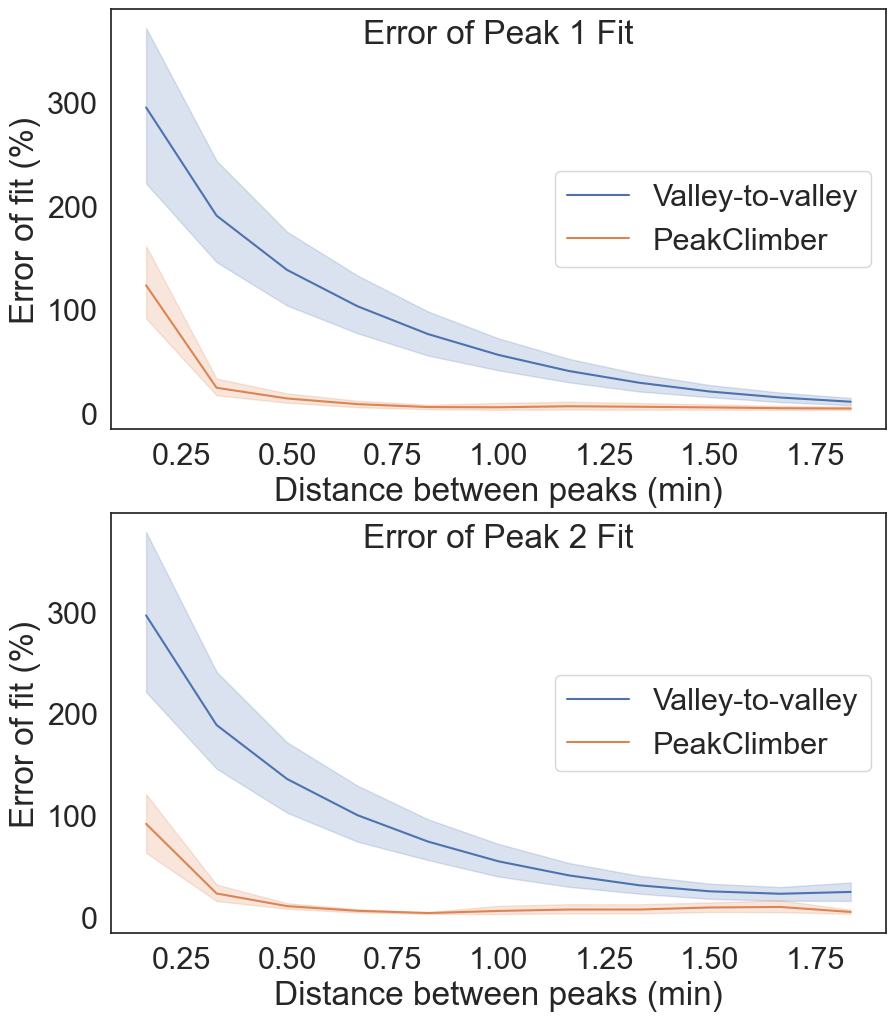

In [12]:
fig,ax=plt.subplots(2,1,figsize=(10,12))
sns.lineplot(x="Distance",y="E1 Thermo %",data=error_df,ax=ax[0],label="Valley-to-valley")

sns.lineplot(x="Distance",y="E1 PeakClimber %",data=error_df,ax=ax[0],label="PeakClimber")

sns.lineplot(x="Distance",y="E2 Thermo %",data=error_df,ax=ax[1],label="Valley-to-valley")

sns.lineplot(x="Distance",y="E2 PeakClimber %",data=error_df,ax=ax[1],label="PeakClimber")

ax[0].set(xlabel="Distance between peaks (min)",ylabel="Error of fit (%)")
ax[0].set_title("Error of Peak 1 Fit",y=0.9)
ax[1].set(xlabel="Distance between peaks (min)",ylabel="Error of fit (%)")
ax[1].set_title("Error of Peak 2 Fit",y=0.9)
ax[0].legend(loc=7)
ax[1].legend(loc=7)
#sns.lineplot(x="Distance",y="E3 PeakClimber",data=error_df)




(0.0, 100.0)

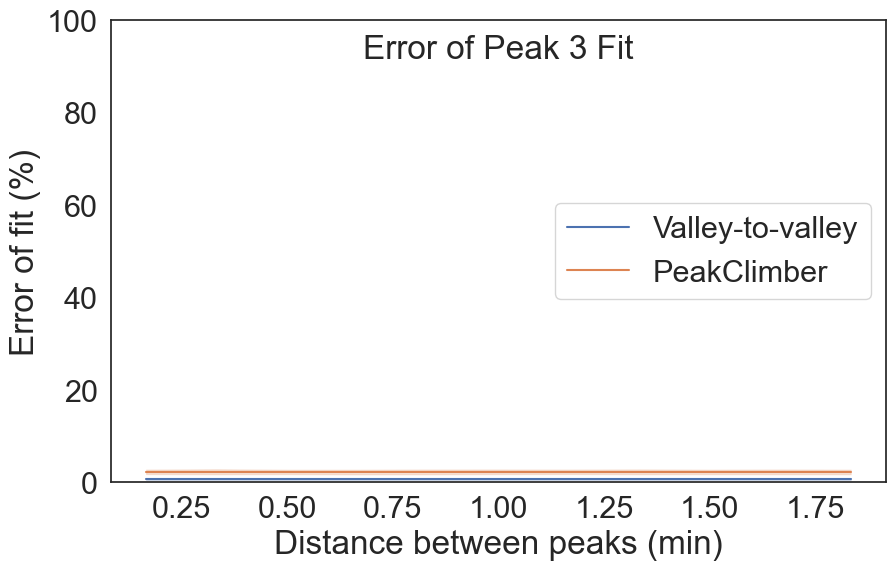

In [13]:
fig,ax=plt.subplots(1,1,figsize=(10,6))

sns.lineplot(x="Distance",y="E3 Thermo %",data=error_df,ax=ax,label="Valley-to-valley")

sns.lineplot(x="Distance",y="E3 PeakClimber %",data=error_df,ax=ax,label="PeakClimber")
ax.set(xlabel="Distance between peaks (min)",ylabel="Error of fit (%)")
ax.legend(loc=7)
ax.set_title("Error of Peak 3 Fit",y=0.9)
ax.set_ylim(0,100)

# Figure 2C + Supplement Figure 2B

In [14]:
error_matrix=[]
for dh in [dha_alone5,dha_alone5_3,dha_alone5_5,
          dha_alone10,dha_alone10_2,dha_alone10_3,dha_alone10_4,dha_alone10_5,
          la_alone10,la_alone10_2,la_alone10_3,la_alone10_4,la_alone10_5,
          la_alone5,la_alone5_2,la_alone5_3,la_alone5_4,la_alone5_5,
          ara_alone10,ara_alone10_2,ara_alone10_3,ara_alone10_4,ara_alone10_5,
          ara_alone5,ara_alone5_2,ara_alone5_3,ara_alone5_4,ara_alone5_5]:
    for modifier in [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
        dh=normalize_area(dh)
        array,center,maximum=concatenate(dh,dh,dh,450,6000,"111",modifier)
        conc=pd.DataFrame(array)
        a=find_peak_areas(conc,10,30,"111",canonical_peaks=[center,center+450/600,center+10],canonical_heights=[maximum,maximum*modifier,maximum])
        if len(a)==3:
            e1_pc=find_error(dh[6000:18000,0].astype(float),dh[6000:18000,2].astype(float),a[0][0],a[0][1],a[0][2],a[0][3],1)
            
            e2_pc=find_error(dh[6000:18000,0].astype(float),dh[6000:18000,2].astype(float)*modifier,a[1][0]-450/600,a[1][1],a[1][2],a[1][3],modifier)
            e3_pc=find_error(dh[6000:18000,0].astype(float),dh[6000:18000,2].astype(float),a[2][0]-10,a[2][1],a[2][2],a[2][3],1)
            e1_thermo=find_thermo_error(dh[5939:12000,0],dh[5939:12000,2].astype(float),0,conc,10,center+450/1200,0.33)

            e2_thermo=find_thermo_error(dh[5939:12000,0].astype(float),dh[5939:12000,2].astype(float)*modifier,450,conc,center+450/1200,17,0.33*modifier)
            e3_thermo=find_thermo_error(dh[5939:12000,0].astype(float),dh[5939:12000,2].astype(float),6060,conc,17,30,0.33)
          
        error_matrix.append({"E1 PeakClimber":e1_pc,"E2 PeakClimber":e2_pc,"E3 PeakClimber":e3_pc,
                             "E1 Thermo":e1_thermo,"E2 Thermo":e2_thermo,"E3 Thermo":e3_thermo,
                             "Peak Ratio":modifier})
error_df=pd.DataFrame(error_matrix)

0.013189447012936775
3.1111121549699003
0.013144713766776865
0.013656497733110343
0.4794732726460658
0.013144715415511177
0.014090433132311175
0.18960907998193083
0.013144713563647324
0.01425422246829142
0.08494822482919934
0.013144713560450575
0.014350762324059985
0.051809766518828355
0.013144713561238572
0.01442752849219843
0.0376118815373013
0.013144713559289941
0.014402958834944595
0.02931321852282334
0.01314471356634775
0.014355416724387015
0.024302849395103358
0.013144713525613742
0.014329311159804885
0.021214691498729406
0.013144713553366608
0.014325257544058301
0.01919432807291864
0.013144713521138818
0.01434331820795316
0.017805780161632017
0.013144713522158515
0.011490322438681151
2.187643964964541
0.010975361642708103
0.015181023213189544
0.44018072878101516
0.010975345400337466
0.011696147327978159
0.0404252099985349
0.010975345400322004
0.011498476247618274
0.02021584298672576
0.010975345400309998
0.011436944456814294
0.01564657575230703
0.010975345400470925
0.011427199305

0.15658450665629425
1.1405853008669338
0.03402119794464723
0.1461366534498526
0.594265497844481
0.03402119796191574
0.13849350742075267
0.364704122381079
0.03402119797461073
0.13221957745499713
0.24842941957251777
0.03402119798815469
0.12657548803890234
0.18186480082570453
0.03402119799979789
0.12145735587020184
0.14074600780189428
0.034021198011710024
0.11661866582921886
0.11368952565717812
0.03402119802140629
0.11207066508855791
0.09514465839543906
0.034021198034388314
0.06433457784573592
3.2933875588435995
0.06431745087150709
0.06521181236421329
2.4489191696453982
0.06431839489950135
0.07058573003214168
1.2595704362651725
0.06431722223580524
0.07239788834454153
0.5807223708313421
0.06431713726575496
0.0728110600658351
0.33063041582659525
0.0643171309434245
0.07289479889442964
0.221166521964149
0.06431712881563299
0.0729487358201104
0.16585435411081212
0.06431711625018893
0.07302295163684522
0.1345615388010404
0.0643171154835549
0.07312436735847748
0.11533235614161043
0.0643171293995

0.08376092802956162
0.04453646997801333
0.027161835380496584
0.10151965644524093
0.07147013161017614
0.02716183829123477
0.12681581667826364
0.06173436199491261
0.027161780237529676
0.1536947848469207
0.053839778611382935
0.027161736168820325
0.015674703762738558
10.28148721724299
0.013749499912659379
0.017482052466682566
0.5482895359321354
0.013749498358718129
0.014489166539607882
0.07082283058927698
0.013749498358102913
0.014408806694506336
0.03430793874402049
0.01374949835718723
0.014411938292200242
0.024560559460470574
0.013749498361053736
0.014430884860739963
0.02055601352585935
0.013749498357598183
0.014452973173782422
0.018509839231509624
0.013749498350974266
0.014478769588667752
0.017315882386573184
0.013749498354030313
0.014510719489162513
0.016553819836948227
0.01374949835988468
0.014534488175661853
0.016034578116483105
0.013749498354465706
0.014565114783845427
0.01566350086104564
0.013749498359749012
0.03526866505662295
10.715199444328855
0.014623193864926946
0.0905381417894

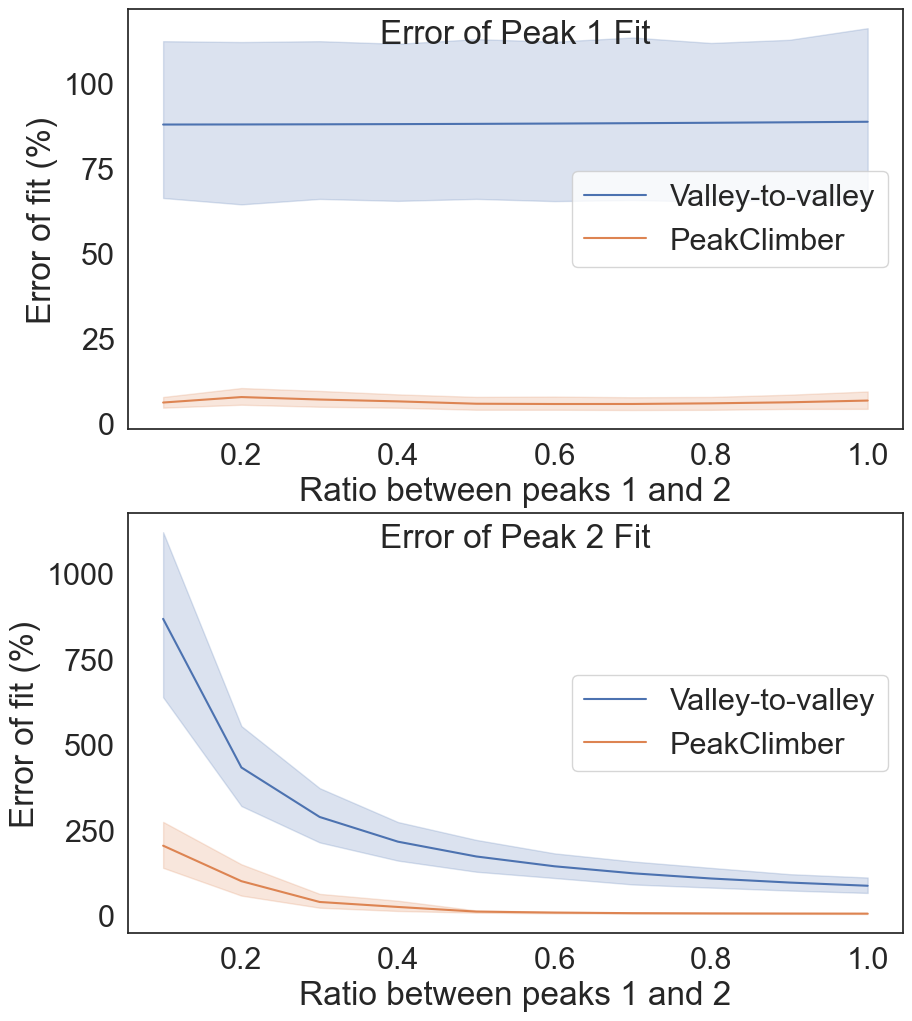

In [19]:
error_df["E1 Thermo %"]=error_df["E1 Thermo"]*100
error_df["E2 Thermo %"]=error_df["E2 Thermo"]*100
error_df["E3 Thermo %"]=error_df["E3 Thermo"]*100

error_df["E1 PeakClimber %"]=error_df["E1 PeakClimber"]*100
error_df["E2 PeakClimber %"]=error_df["E2 PeakClimber"]*100
error_df["E3 PeakClimber %"]=error_df["E3 PeakClimber"]*100

fig,ax=plt.subplots(2,1,figsize=(10,12))
sns.lineplot(x="Peak Ratio",y="E1 Thermo %",data=error_df[error_df["Peak Ratio"]>=0.1],ax=ax[0],label="Valley-to-valley")

sns.lineplot(x="Peak Ratio",y="E1 PeakClimber %",data=error_df[error_df["Peak Ratio"]>=0.1],ax=ax[0],label="PeakClimber")

sns.lineplot(x="Peak Ratio",y="E2 Thermo %",data=error_df[error_df["Peak Ratio"]>=0.1],ax=ax[1],label="Valley-to-valley")

sns.lineplot(x="Peak Ratio",y="E2 PeakClimber %",data=error_df[error_df["Peak Ratio"]>=0.1],ax=ax[1],label="PeakClimber")

ax[0].set(xlabel="Ratio between peaks 1 and 2",ylabel="Error of fit (%)")
ax[0].set_title("Error of Peak 1 Fit",y=0.9)
ax[0].legend(loc=7)
ax[1].set(xlabel="Ratio between peaks 1 and 2",ylabel="Error of fit (%)")
ax[1].set_title("Error of Peak 2 Fit",y=0.9)
ax[1].legend(loc=7)
#sns.lineplot(x="Distance",y="E3 PeakClimber",data=error_df)

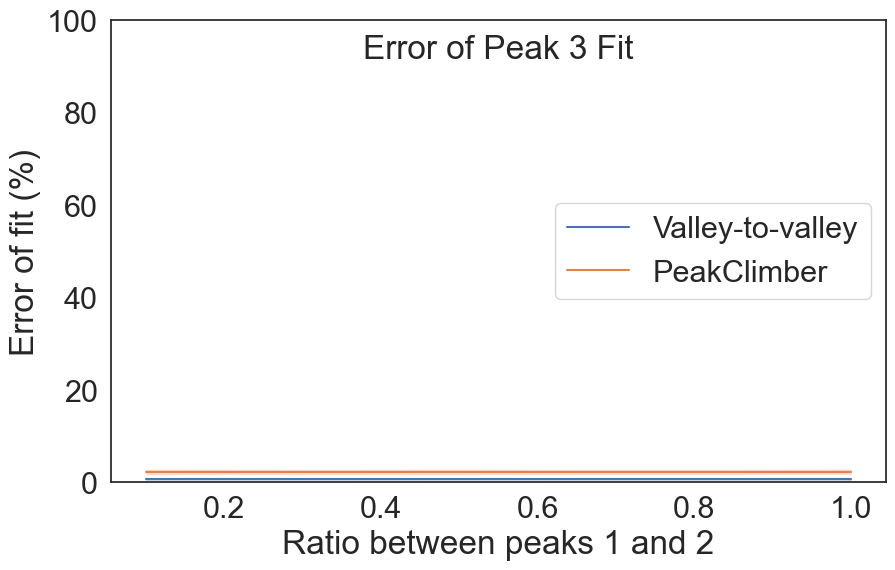

In [18]:
fig,ax=plt.subplots(1,1,figsize=(10,6))
sns.lineplot(x="Peak Ratio",y="E3 Thermo %",data=error_df[error_df["Peak Ratio"]>=0.1],ax=ax,label="Valley-to-valley")

sns.lineplot(x="Peak Ratio",y="E3 PeakClimber %",data=error_df[error_df["Peak Ratio"]>=0.1],ax=ax,label="PeakClimber")
ax.set(xlabel="Ratio between peaks 1 and 2",ylabel="Error of fit (%)")
ax.set_title("Error of Peak 3 Fit",y=0.9)
ax.set_ylim(0,100)
ax.legend(loc=7)